In [433]:
## import packages and helper functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import torch
import torch.nn as nn
import statistics
import copy

training data

In [434]:
# import data
df = pd.read_csv("data/test_dataset.csv")
data = df.to_numpy()
(l, w) = data.shape

In [435]:
x_train = np.zeros((l, w*2))
for i in range(l):
    for d in range(w):
        p = data[i, d]
        # update output array
        if p == 0: 
            x_train[i, d*2] = p # 0 score
            x_train[i, d*2+1] = p # missing indicator
        else:
            x_train[i, d*2] = p # score
            x_train[i, d*2+1] = 1-p # 1-score
x_train

array([[0.89796591, 0.10203409, 0.05792755, 0.94207245],
       [0.42342865, 0.57657135, 0.7534337 , 0.2465663 ],
       [0.65212126, 0.34787874, 0.85198655, 0.14801345],
       ...,
       [0.83388104, 0.16611896, 0.35454279, 0.64545721],
       [0.26978704, 0.73021296, 0.2199427 , 0.7800573 ],
       [0.50115658, 0.49884342, 0.77590825, 0.22409175]])

In [436]:
# x_train = data.reshape((-1, 28))
# x_train.shape

Autoencoder model

In [437]:
(l, w)

(500, 2)

In [438]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n_domains = 2
         
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(n_domains * 2, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 1)
        )
         
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(1, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, n_domains * 2),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [439]:
# Model Initialization
model = AE()
 
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
 
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-3,
                             weight_decay = 1e-8)

In [440]:
def missing(arr):
    # print(arr)
    return arr[0] == arr[1] and arr[0] == 0

In [441]:
epochs = 20
outputs = []
losses = []
epoch_loss = []
for epoch in range(epochs):
    for session in x_train:

      # Output of Autoencoder
      session_rs = session.reshape(-1, w * 2)
      session_t = torch.from_numpy(session_rs)
      session_t = session_t.clone().detach().requires_grad_(True).type(torch.float32)
      reconstructed = model(session_t)

      # handle missing value
      missing_exists = False
      missing_domains = []
      for domain in range(w):
        if missing(session[domain*2:domain*2+2]):
          missing_exists = True
          missing_domains.append(domain)
          
      if missing_exists:
        session_dc = copy.deepcopy(session)
        for d in missing_domains:
          target = reconstructed.detach().numpy()[0][d*2:d*2+2]
          session_dc[d*2:d*2+2] = target
        session_dc = session_dc.reshape(-1, w * 2)
        session_t = torch.from_numpy(session_dc)
        session_t = session_t.clone().detach().requires_grad_(True).type(torch.float32)
       
      # Calculating the loss function
      loss = loss_function(reconstructed, session_t)
       
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
       
      # Storing the losses in a list for plotting
      epoch_loss.append(loss.item())
    losses.append(statistics.mean(epoch_loss))
    epoch_loss = []
    outputs.append((epochs, session_t, reconstructed))

Epoch [1/20], Loss: 0.1730
Epoch [1/20], Loss: 0.0405
Epoch [1/20], Loss: 0.0836
Epoch [1/20], Loss: 0.0705
Epoch [1/20], Loss: 0.1468
Epoch [1/20], Loss: 0.0743
Epoch [1/20], Loss: 0.0361
Epoch [1/20], Loss: 0.2390
Epoch [1/20], Loss: 0.2322
Epoch [1/20], Loss: 0.1311
Epoch [1/20], Loss: 0.0612
Epoch [1/20], Loss: 0.0144
Epoch [1/20], Loss: 0.0995
Epoch [1/20], Loss: 0.0294
Epoch [1/20], Loss: 0.0765
Epoch [1/20], Loss: 0.0829
Epoch [1/20], Loss: 0.1223
Epoch [1/20], Loss: 0.0523
Epoch [1/20], Loss: 0.0515
Epoch [1/20], Loss: 0.1030
Epoch [1/20], Loss: 0.1354
Epoch [1/20], Loss: 0.0626
Epoch [1/20], Loss: 0.1003
Epoch [1/20], Loss: 0.0634
Epoch [1/20], Loss: 0.0880
Epoch [1/20], Loss: 0.1208
Epoch [1/20], Loss: 0.0729
Epoch [1/20], Loss: 0.0236
Epoch [1/20], Loss: 0.0402
Epoch [1/20], Loss: 0.1131
Epoch [1/20], Loss: 0.1034
Epoch [1/20], Loss: 0.0404
Epoch [1/20], Loss: 0.1116
Epoch [1/20], Loss: 0.2032
Epoch [1/20], Loss: 0.1333
Epoch [1/20], Loss: 0.1164
Epoch [1/20], Loss: 0.1881
E

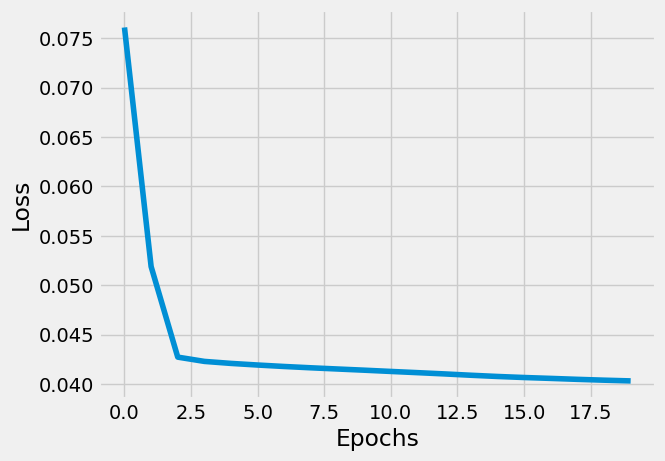

In [442]:
 # Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Plotting
with torch.no_grad():
   plt.plot(losses[-200:])

Debug

In [424]:
temp = np.array([0.0, 0.0, 0.0, 0.0])

In [432]:
# Output of Autoencoder
session_rs = temp.reshape(-1, w * 2)
session_t = torch.from_numpy(session_rs)
session_t = session_t.clone().detach().requires_grad_(True).type(torch.float32)
reconstructed = model(session_t)
print(session_t)
print(reconstructed)

# handle missing value
missing_exists = False
missing_domains = []
for domain in range(w):
    if missing(temp[domain*2:domain*2+2]):
        missing_exists = True
        missing_domains.append(domain)
print(missing_exists, missing_domains)
if missing_exists:
    session_dc = copy.deepcopy(temp)
    for d in missing_domains:
        target = reconstructed.detach().numpy()[0][d*2:d*2+2]
        print(d, target)
        session_dc[d*2:d*2+2] = target
    session_dc = session_dc.reshape(-1, w * 2)
    session_t = torch.from_numpy(session_dc)
    session_t = session_t.clone().detach().requires_grad_(True).type(torch.float32)
    print(session_t)

tensor([[0., 0., 0., 0.]], grad_fn=<ToCopyBackward0>)
tensor([[0.5032, 0.4357, 0.3051, 0.6851]], grad_fn=<SigmoidBackward0>)
True [0, 1]
0 [0.5032409  0.43565983]
1 [0.30510497 0.68506205]
tensor([[0.5032, 0.4357, 0.3051, 0.6851]], grad_fn=<ToCopyBackward0>)
